<a href="https://colab.research.google.com/github/DamianDominoDavis/sommalier/blob/master/sommalier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# V.1 Exploring the green reds

Write a function that will plot a scatterplot matrix of your red wine data. Your function should plot wines with quality over some “good_threshold” as one color, and wines below some “bad_threshold” as another. Your plotting function should have the option to save a .png of your plots. Here’s an example function definition:

> `def plot_scatter_matrix(wine_data, good_threshold, bad_threshold, save_plot=False)`

Now that you’ve had a chance to analyze different chemical factors in red wines and their relationship with high scores (8 or higher) and low scores (3 or lower), which factors do you think will be most useful to your perceptron for distinguishing high quality vs. low quality wines? Why?

> Correlation within good and bad groups is less important than clear distinction between the two. Which, if any, of these axes will be separable depends as much on the threshold selections as the input data. For thresholds 8 and 3, see alcohol/pH/chlorides in the lower-right (all good); compare other axes.

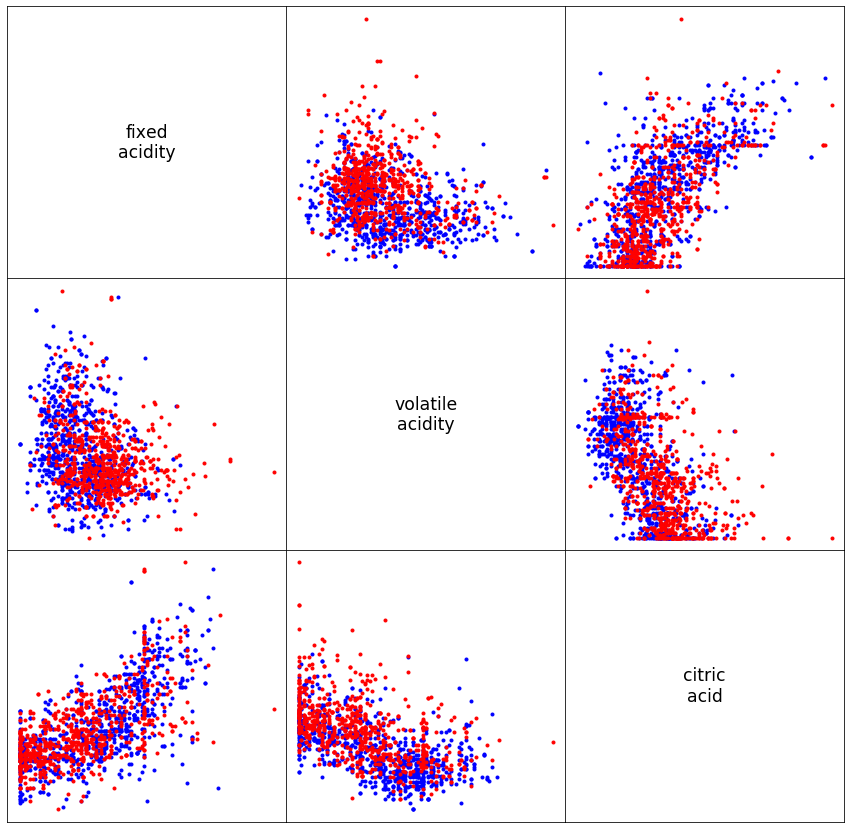

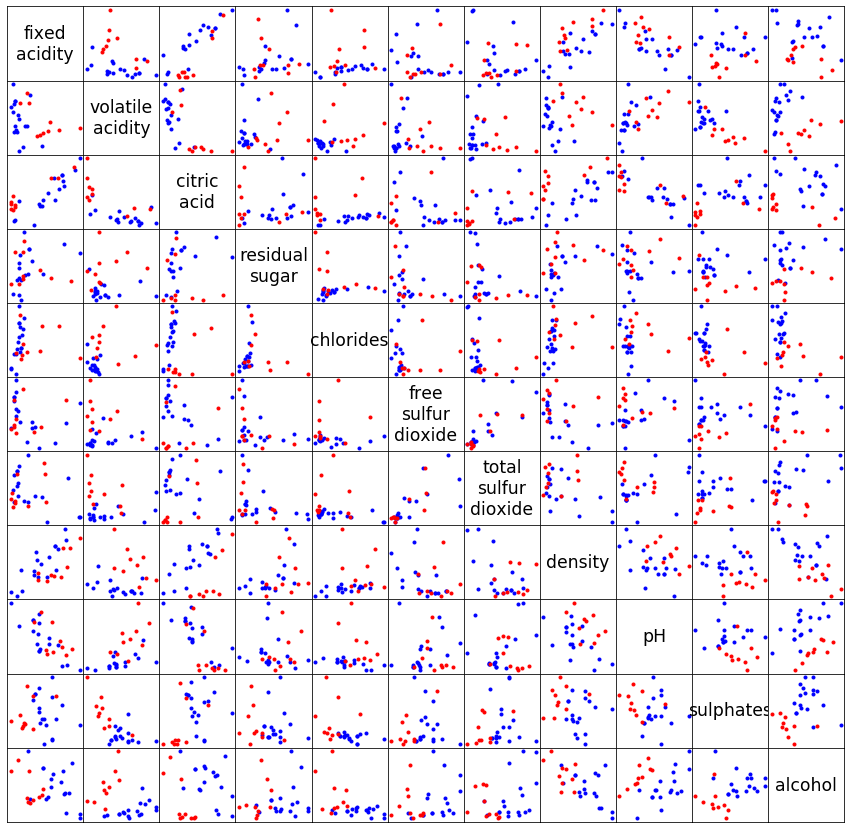

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_scatter_matrix(data, good_threshold, bad_threshold, save=False):
    good = data[data['quality'] >= good_threshold]
    bad = data[data['quality'] <= bad_threshold]
    features = [_ for _ in data if _ != 'quality']
    txt_args = {'size': 'xx-large',
                'horizontalalignment': 'center',
                'verticalalignment': 'center'}
    fig = plt.figure(figsize=[15, 15])
    fig.subplots_adjust(wspace=0, hspace=0)
    ax = fig.subplots(len(features), len(features))
    for row, rfeature in enumerate(features):
        for col, cfeature in enumerate(features):
            ax[row,col].get_xaxis().set_visible(False)
            ax[row,col].get_yaxis().set_visible(False)
            if row == col:
                ax[row,col].text(0.5, 0.5, rfeature.replace(' ', '\n'), txt_args)
            else:
                ax[row,col].plot(rfeature, cfeature, 'b.', data=good)
                ax[row,col].plot(rfeature, cfeature, 'r.', data=bad)
    plt.show(fig)
    if save:
        return fig.savefig('v1.png', dpi=100)

url = 'https://raw.githubusercontent.com/DamianDominoDavis/sommalier/master/winequality-red.csv'
data = pd.read_csv(url, sep=';')
small = data[['fixed acidity', 'volatile acidity', 'citric acid', 'quality']]
plot_scatter_matrix(small, 6, 5)
plot_scatter_matrix(data, 8, 3)


# V.2 Learning to perceptron
Now that you’ve explored the red wines, it’s time to put together a perceptron
that can learn to classify the wines as “good” or “bad” based on only chemical
attributes!

Implement a perceptron that:
- Has randomly initialized weights and bias
- Uses the Rosenblatt perceptron learning rule (with changeable learning rate)
- Utilizes the heaviside step activation function (discrete version)

Train on 2 chemical factors (for example, alcohol and pH) and only use red
wines with a score of 8 or higher and wines with a score of 3 or lower.
- Have a way to specify number of training epochs
- Train your perceptron until it makes no errors, if training epochs is set to 0,
- Have a way to specify learning rate.
- Return a list of python tuples containing (performance):

> `[(current_epoch, num_errors_at_epoch_end, [array_of_weights], bias), ... ]`

Take the output of your perceptron training function and your red wine data and generate two plots in one figure:
- errors as a function of epoch
- the decision boundary of your perceptron, ‘good’ and ‘bad’ wine data points,
areas
- Your function should accept a specific epoch to see the decision boundary of the perceptron on that epoch. If a negative
epoch is given, cause the plots to show the last epoch.

Your perceptron appears to work... but why is it taking so many epochs to train?
Maybe you can modify the red wine data to help the perceptron learn more
quickly? Use the function you just created in part c) to plot and verify that
your perceptron is learning more efficiently!


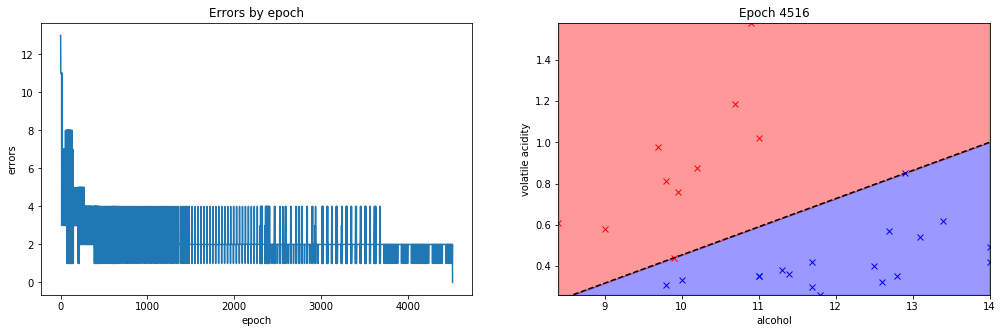

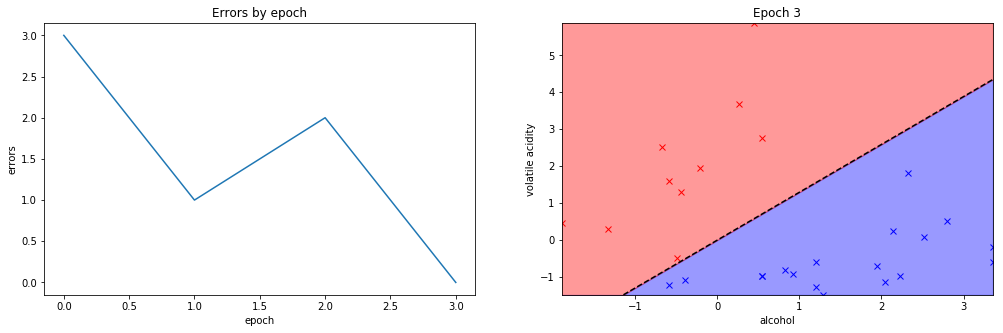

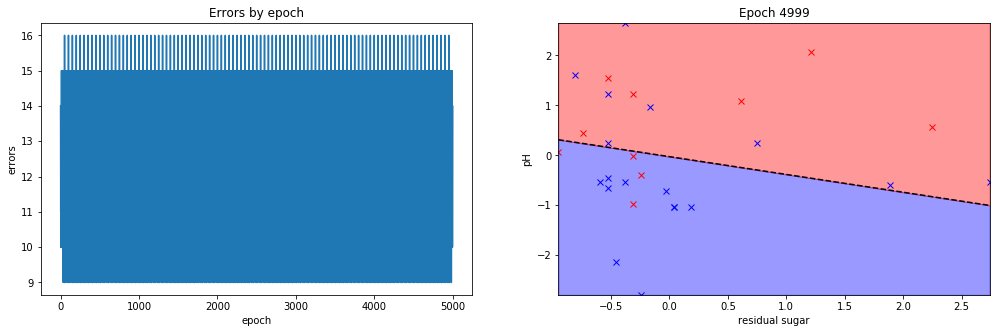

In [2]:
import random

def transform(data, features):
    data[features[:-1]] = (data[features[:-1]] - data[features[:-1]].mean()) / data[features[:-1]].std()
    return data

def dot(a, b):
    if len(a) != len(b):
        raise ValueError('arguments have different length')
    return sum(ai*bi for ai,bi in zip(a,b))

def h_step_func(y, ref):
    return y.map(lambda x: int(x>=ref))


class Perceptron(object):
    def __init__(self, lr):
        self.w = None
        self.lr = lr
        self.log = list()
    
    def net_input(self, X):
        return dot(self.w[1:], X) + self.w[0]
    
    def predict(self, X):
        return int(self.net_input(X) > 0.0)
    
    # def accuracy(self, X, y):
    #     expected = sum(int(self.predict(xi) == yi) for xi,yi in zip(X,y))
    #     correct = expected / len(y)
    #     print('{0:.2f}%% correct'.format(100*correct))
    #     return correct

    def train(self, X, y, epochs):
        if epochs <= 0:
            raise ValueError('Perceptron needs positive target epoch, not {}' % epochs)
        if not self.w:
            self.w = [0.001 * random.uniform(-1, 1) for _ in range(X.shape[1] + 1)]
        epoch = 0
        errors = 1
        while errors and epoch<epochs:
            errors = 0
            for output,expected in zip(X,y):
                delta = self.lr * (expected - self.predict(output))
                self.w[0] += delta
                self.w[1:] += delta * output
                errors += int(delta != 0.0)
            self.log.append((epoch, errors, self.w[1:], self.w[0]))
            epoch += 1
        return self.log



def report(log, data, features, good, bad, epoch=-1, save=False):
    if epoch == -1:
        epoch = len(log) - 1
    if not 0<=epoch<len(log):
        raise ValueError('can\'t target epoch {}'.format(epoch))
    if len(features) != 2:
        raise ValueError('can\'t graph {} dimensions'.format(len(features)))
    fig, (ax,bx) = plt.subplots(1, 2, figsize=(17,5))

    # left graph
    epochs = [_[0] for _ in log[:epoch + 1]]
    errors = [_[1] for _ in log[:epoch + 1]]
    ax.set_title('Errors by epoch')
    ax.set_xlabel('epoch')
    ax.set_ylabel('errors')
    ax.plot(epochs, errors)

    # right
    x = [x_min,x_max] = min(data[features[0]]), max(data[features[0]])
    y = [y_min,y_max] = min(data[features[1]]), max(data[features[1]])
    bx.set_title('Epoch {}'.format(epoch))
    bx.set_xlabel(features[0])
    bx.set_ylabel(features[1])
    bx.set_xlim(x)
    bx.set_ylim(y)
    
    # right scatter
    good_wines = data[(data['quality'] >= good)]
    bad_wines = data[(data['quality'] <= bad)]
    bx.plot(features[0], features[1], 'bx', data=good_wines, label='good >= {}'.format(good))
    bx.plot(features[0], features[1], 'rx', data=bad_wines, label='bad <= {}'.format(bad))
    # bx.legend(bbox_to_anchor=(1.05, 1), loc=2)
    
    # right divide
    w2, w1 = log[epoch][2]
    b = log[epoch][3]
    slope = -w1/w2
    intercept = -b/w2
    k = [slope * xi + intercept for xi in x]
    bx.plot(x, k, 'k--')
    bx.fill_between(x, k, y_min, color='blue', alpha='0.4')
    bx.fill_between(x, k, y_max, color='red', alpha='0.4')
    
    if save:
        plt.savefig('./v2.png', dpi=100)
    return fig


url = 'https://raw.githubusercontent.com/DamianDominoDavis/sommalier/master/winequality-red.csv'
data = pd.read_csv(url, sep=';')
features = ['volatile acidity', 'alcohol', 'quality']
small = data[(data['quality'] >= 8) | (data['quality'] <= 3)][features]
small = small.reset_index(drop=True)
X = small[features[:-1]].values
y = h_step_func(small['quality'], 8)
p = Perceptron(0.005)
log = p.train(X, y, 5000)
fig = report(log, small, [features[1], features[0]], 7, 4)
plt.show(fig)

data = transform(data, features)
small = data[(data['quality'] >= 8) | (data['quality'] <= 3)][features]
small = small.reset_index(drop=True)
X = small[features[:-1]].values
y = h_step_func(small['quality'], 8)
p = Perceptron(0.005)
log = p.train(X, y, 10)
fig = report(log, small, [features[1], features[0]], 7, 4)
plt.show(fig)

features = ['pH', 'residual sugar', 'quality']
data = transform(data, features)
small = data[(data['quality'] >= 8) | (data['quality'] <= 3)][features]
small = small.reset_index(drop=True)
X = small[features[:-1]].values
y = h_step_func(small['quality'], 8)
p = Perceptron(0.005)
log = p.train(X, y, 5000)
fig = report(log, small, [features[1], features[0]], 7, 4)
plt.show(fig)


# V.3 My fair ADALINE

Encouraged by the results of your perceptron, you decide to see if you can use
it to distinguish between wines with a score of 4 and lower, and wines with a
score of 7 and higher. Feeling confident, you decide to let the perceptron
train until it can find the best decision boundary.

Marvin notices and chides you for torturing your perceptron. Why?

> The perceptron must train to zero errors or some epoch limit; it can't reach
zero errors on unseparable data, or just sensibly bail.

Implement an ADALINE that:
- Has randomly initialized weights and bias
- Uses a linear activation function and some kind of quantizer
- Uses the Widrow-Hoff learning rule

Train your ADALINE. Your training function should:
- Take in your red wine data as a parameter
- Have a way to specify number of training epochs
- If training epochs is set to 0, your ADALINE should train until it converges
on a good set of weights.
- Have a way to specify learning rate.
- Have an option to perform either online learning or batch learning

Find a good learning rate, plot classification errors vs. epoch and decision
boundary. What settings tend to give the smallest number of classification
errors?

> Hypersensitive learn rates (1&gt;&asymp;) about immediately accumulate errors
faster than precision; we can bail as early as cost rises. Insensitive values
close to 0 take dramatically longer, and for not a lot of return on precision.


Learn rate = 0.5	77.14% accurate


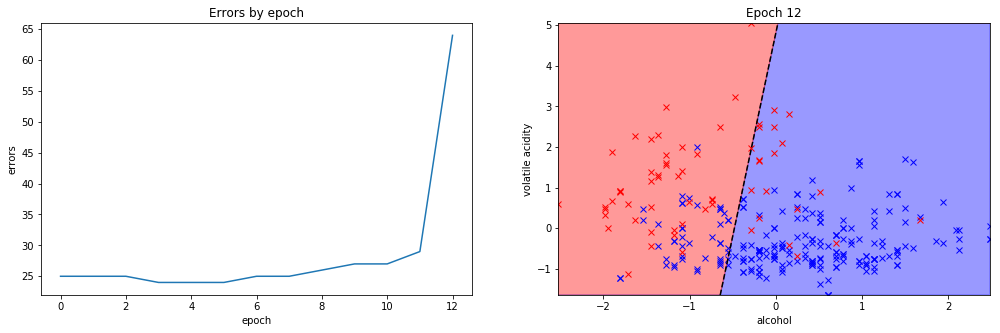

Learn rate = 0.1	90.00% accurate


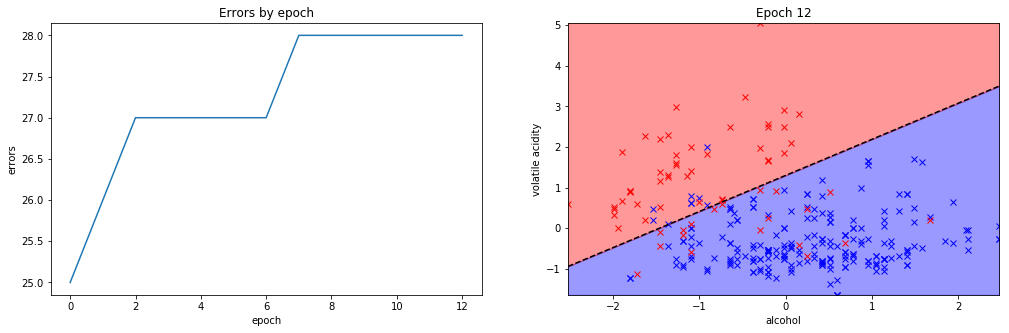

Learn rate = 0.05	90.00% accurate


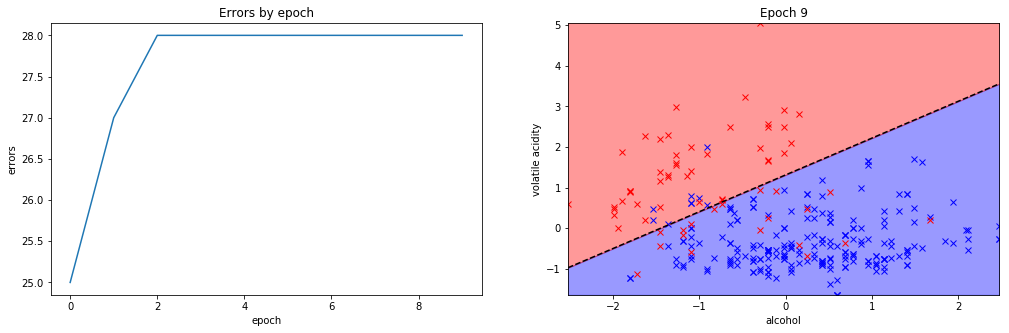

Learn rate = 0.01	90.00% accurate


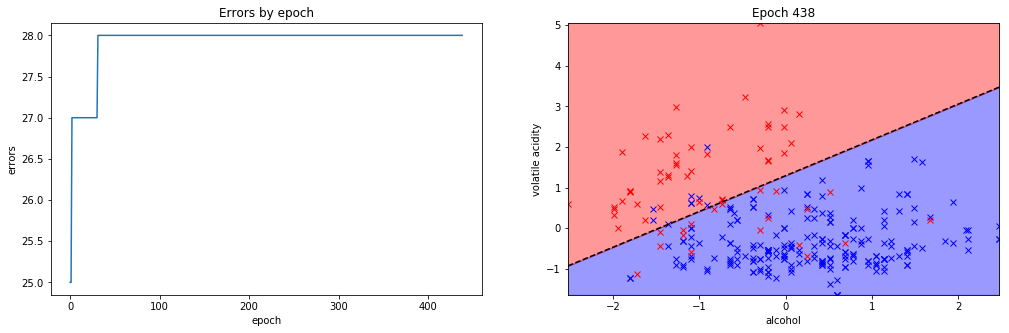

Learn rate = 0.005	90.00% accurate


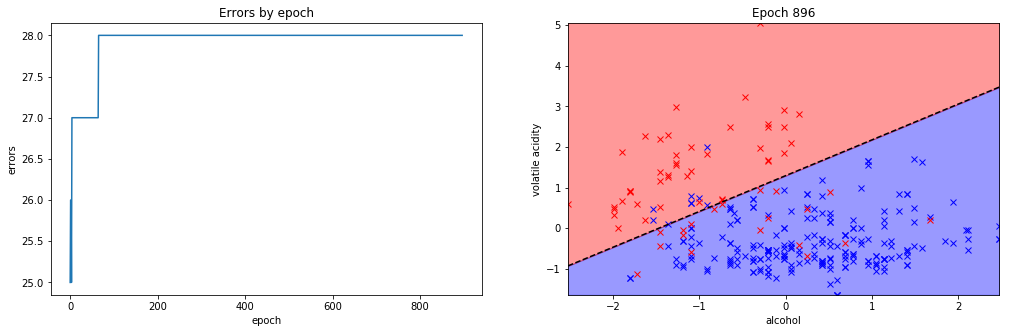

In [3]:
import math

class Adaline(object):
    def __init__(self, lr):
        self.w = None
        self.lr = lr
        self.performance = list()

    def net_input(self, X):
        return dot(self.w[1:], X) + self.w[0]
    
    ''' linear activation function '''
    def activate(self, X):
        return 1 / (1 + math.exp(-self.net_input(X)))
    
    ''' some kind of quantizer '''
    def predict(self, X):
        return int(self.activate(X) > 0.5)
    
    def accuracy(self, X, y):
        acc = (len(y) - self.eval(X,y)) / len(y)
        print('{0:.2f}% accurate'.format(100*acc))
        return acc
    
    def eval(self, X, y):
        num_missclass = [int(self.predict(xi) != yi) for xi, yi in zip(X, y)]
        return sum(num_missclass)
    
    ''' Widrow-Hoff learning rule '''
    def _train_epoch(self, X, y, epoch, batch):
        errors = list()
        for xi, yi in zip(X, y):
            e = yi - self.activate(xi)
            errors.append(e)
            if not batch:
                self.w[0] += self.lr * e
                self.w[1:] += self.lr * e * xi
        if batch:
            self.w[0] += self.lr * sum(errors)
            self.w[1:] += self.lr * dot(X, errors)
        num_missclass = self.eval(X, y)
        self.performance.append((epoch, num_missclass, self.w[1:], self.w[0]))
        return errors

    ''' specify number of training epochs or 0, learning rate, online/batch learning '''
    def train(self, X, y, epochs=0, batch=True):
        if epochs < 0:
            raise ValueError('invalid number of training epochs')        
        ''' randomly initialized weights and bias '''
        if self.w is None:
            self.w = [0.0001 * random.uniform(-1, 1) for i in range(X.shape[1] + 1)]
        epoch = last = epoch_errors = 0
        while True:
            last = epoch_errors
            epoch_errors = self._train_epoch(X, y, epoch, batch)
            epoch += 1
            if epochs != 0 and epoch == epochs:
                break
            elif epochs == 0 and epoch > 3 and sum(x**2 for x in last) < sum(x**2 for x in epoch_errors):
                ''' until it converges on a good set of weights '''
                break
        return self.performance

url = 'https://raw.githubusercontent.com/DamianDominoDavis/sommalier/master/winequality-red.csv'
data = pd.read_csv(url, sep=';')
features = ['volatile acidity', 'alcohol', 'quality']
good, bad = 7,4
small = data[(data['quality'] >= good) | (data['quality'] <= bad)][features]
small = transform(small, features)
small = small.reset_index(drop=True)
X = small[features[:-1]].values
y = h_step_func(small['quality'], good)
for lr in [0.5, 0.1, 0.05, 0.01, 0.005]:
    print('Learn rate = {}'.format(lr), end='\t')
    ad = Adaline(lr)
    log = ad.train(X, y)
    ad.accuracy(X, y)
    fig = report(log, small, [features[1], features[0]], good, bad)
    plt.show(fig)


# V.4 Advanced wine sampling and resampling

Write a function that uses the holdout method to partition the red wine data
into a training and a validation set. The function should take a parameter to
adjust the proportion of training to validation data. It should return a tuple
containing:
> `(training_pandas_dataframe, validation_pandas_dataframe)`

Write a function that generates a k-fold cross-validation dataset from the
red wine data. The function should allow k to be arbitrarily adjusted and also
have an optional setting to shuffle data before creating k-folds. The function
should return a list of ‘k’ tuples with each tuple containing:
> `(training_pandas_dataframe, cross_validation_pandas_dataframe)`

What effects does changing learning rate and number of training epochs have
on the ADALINE when evaluated via k-fold cross-validation? To address this
question, you should write (or modify) a function that will train and assess
the ADALINE on each training and cross-validation fold produced by your k-fold
function.

In [4]:
def train_test_split(data, perc=0.7):
    train = data.sample(frac=perc)
    hold = data.drop(train.index)
    return train, hold

def k_fold_split(data, k=5, shuffle=True):
    folds = list()
    if shuffle:
        data = data.sample(frac=1).reset_index(drop=True)
    for i in range(k):
        width = data.shape[0] // k + int(i < data.shape[0] % k)
        hold = data.iloc[i*width:(i+1)*width, :]
        train = data.iloc[data.index.difference(hold.index), :]
        folds.append((train, hold))
    return folds

def cross_validate_adaline(folds, features, lr=0.005, epochs=100, good=7, batch=True):
    acc = 0
    for t,h in folds:
        X = t[features[:-1]].values
        y = h_step_func(t['quality'], good)
        ad = Adaline(lr=lr)
        ad.train(X, y, epochs, batch)
        X = h[features[:-1]].values
        y = h_step_func(h['quality'], good)
        acc += ad.accuracy(X, y)
    print('Overall testing accuracy {:.2f}%'.format(100*acc/len(folds)))

url = 'https://raw.githubusercontent.com/DamianDominoDavis/sommalier/master/winequality-red.csv'
data = pd.read_csv(url, sep=';')
features = ['volatile acidity', 'alcohol', 'quality']
good, bad = 7, 4
small = data[(data['quality'] >= good) | (data['quality'] <= bad)][features]
small = transform(small, features)
small = small.reset_index(drop=True)
print('train test split:')
for i in range(5):
    t,h = train_test_split(small, .8)
    print('{}, {}/{}: '.format(i, len(t), len(h)), end='')
    ad = Adaline(0.005)
    X = t[features[:-1]].values
    y = h_step_func(t['quality'], good)
    ad.train(X,y, 100)
    X = h[features[:-1]].values
    y = h_step_func(h['quality'], good)
    ad.accuracy(X,y)

print('\nk-fold split')
folds = k_fold_split(small)
print(' F train  test')
for i,(tr,te) in enumerate(folds):
    print('{:2d} {:5d} {:5d}'.format(i,len(tr),len(te)))

print('\ncross validation')
cross_validate_adaline(folds, features, good=good)


train test split:
0, 224/56: 91.07% accurate
1, 224/56: 83.93% accurate
2, 224/56: 96.43% accurate
3, 224/56: 87.50% accurate
4, 224/56: 82.14% accurate

k-fold split
 F train  test
 0   224    56
 1   224    56
 2   224    56
 3   224    56
 4   224    56

cross validation
87.50% accurate
96.43% accurate
89.29% accurate
91.07% accurate
85.71% accurate
Overall testing accuracy 90.00%


# V.5 Adventures in the Nth dimension

Try training your perceptron/ADALINE with different numbers and types of
chemical factors. Under what circumstances can your perceptron/ADALINE
successfully train?

> accuracy spikes along columns containing separable intersections;
interestingly, so long as a few of those exist, adding remining columns only
seems to narrow precision rather than affect accuracy. This is better than not.

You know what the decision boundary for 2 wine chemical factors looks like, but
what does the decision boundary for 3 factors look like? What about if you use
7 factors? How about if you use all 11 wine chemical factors?

> the boundary is a hyperplane in D-1 dimensions (point, line, plane,
animated volume, phase space...)

In [5]:
url = 'https://raw.githubusercontent.com/DamianDominoDavis/sommalier/master/winequality-red.csv'
data = pd.read_csv(url, sep=';')
features = [f for f in data]
data = transform(data, features)
good, bad = 7, 4

features = ['pH', 'alcohol', 'volatile acidity', 'sulphates', 'fixed acidity']
for D in range(2,len(features)+1):
    small = data[(data['quality'] >= good) | (data['quality'] <= bad)][features+['quality']]
    small = small.reset_index(drop=True)
    folds = k_fold_split(small)
    print('across {} dimensions ({})'.format(D, ', '.join(features[:D])))
    cross_validate_adaline(folds, features[:D], good=good)

print('\n')

features += ['citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density']
for D in range(6,len(features)+1):
    small = data[(data['quality'] >= good) | (data['quality'] <= bad)][features+['quality']]
    small = small.reset_index(drop=True)
    folds = k_fold_split(small)
    print('across {} dimensions ({})'.format(D, ', '.join(features[:D])))
    cross_validate_adaline(folds, features[:D], good=good)


across 2 dimensions (pH, alcohol)
75.00% accurate
76.79% accurate
75.00% accurate
87.50% accurate
67.86% accurate
Overall testing accuracy 76.43%
across 3 dimensions (pH, alcohol, volatile acidity)
87.50% accurate
89.29% accurate
91.07% accurate
78.57% accurate
87.50% accurate
Overall testing accuracy 86.79%
across 4 dimensions (pH, alcohol, volatile acidity, sulphates)
92.86% accurate
85.71% accurate
92.86% accurate
89.29% accurate
83.93% accurate
Overall testing accuracy 88.93%
across 5 dimensions (pH, alcohol, volatile acidity, sulphates, fixed acidity)
87.50% accurate
85.71% accurate
92.86% accurate
91.07% accurate
92.86% accurate
Overall testing accuracy 90.00%


across 6 dimensions (pH, alcohol, volatile acidity, sulphates, fixed acidity, citric acid)
91.07% accurate
87.50% accurate
83.93% accurate
94.64% accurate
92.86% accurate
Overall testing accuracy 90.00%
across 7 dimensions (pH, alcohol, volatile acidity, sulphates, fixed acidity, citric acid, residual sugar)
92.86% accura

# V.6 Marvin’s rebuttal

Although you’ve managed to do a pretty decent job at predicting red wine
quality given chemical characteristics, Marvin is not impressed. He gives you
one more dataset for Pan-Galactic Gargle Blaster and challenges you to solve it
with your *single* perceptron or ADALINE.

While not a wine... find a way to successfully classify the Pan-Galactic Gargle
Blaster dataset. Show that your perceptron or ADALINE successfully classifies
the PanGalactic Gargle Blaster data set by plotting the decision boundary and
also show ‘good’ and ‘bad’ Gargle Blaster data points.

> Two inseparable features means marvin wants me to separate them. Multiquadratic radial basis function. Marvin was kind enough to circularly shape the data in advance, it's also around zero variance after feature standardization.

   wonderflonium  fallian marsh gas  quality
0      -0.160122           1.892045        2
1      -1.431073           0.934545        2
2       1.341882           0.632818        2
3       0.403430           0.161080        9
4      -0.050871           1.670525        2
5       0.190913           0.419837        9
6      -0.974167          -1.355632        1
7       1.179505          -0.790644        1
8       0.554397           0.008666        8
9       1.424156          -0.327724        2


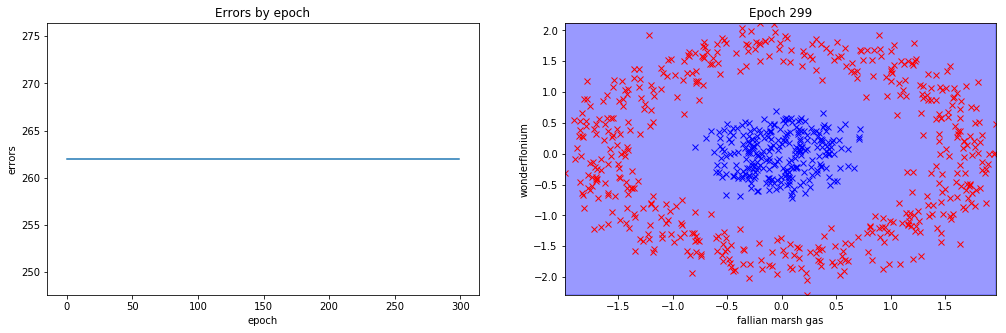

   wonderflonium  fallian marsh gas  quality         r       phi
0      -0.160122           1.892045        2  1.898809  1.731923
1      -1.431073           0.934545        2  1.709194 -0.496527
2       1.341882           0.632818        2  1.483612  1.974700
3       0.403430           0.161080        9  0.434399  0.564510
4      -0.050871           1.670525        2  1.671300  1.619655
5       0.190913           0.419837        9  0.461206  0.610750
6      -0.974167          -1.355632        1  1.669353 -2.329799
7       1.179505          -0.790644        1  1.419982  0.388861
8       0.554397           0.008666        8  0.554465  0.563064
9       1.424156          -0.327724        2  1.461378  1.096432
100.00% accurate


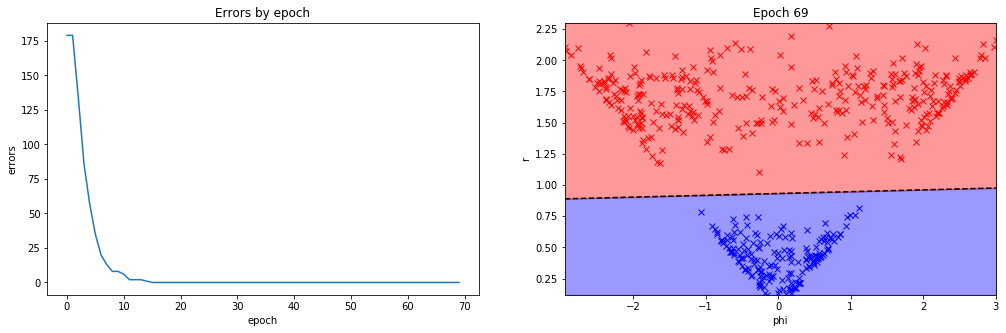

In [6]:
url = 'https://raw.githubusercontent.com/DamianDominoDavis/sommalier/master/Pan%20Galactic%20Gargle%20Blaster.csv'
data = pd.read_csv(url, sep=';')
features = ['wonderflonium', 'fallian marsh gas', 'quality']
good, bad = 8, 4
small = data[(data['quality'] >= good) | (data['quality'] <= bad)][features]
small = transform(small, features)
small = small.reset_index(drop=True)
print(small[:10])

X = small[features[:-1]].values
y = h_step_func(small['quality'], good)
ad = Adaline(0.005)
log = ad.train(X, y, 300)
fig = report(log, small, [features[1], features[0]], good, bad)
plt.show(fig)

small = small.assign(r=lambda x: (x[features[0]]**2 + x[features[1]]**2)**0.5)
small = small.assign(phi=lambda x: x[features[0]] + x[features[1]])
print(small[:10])

t, h = train_test_split(small, 0.7)
X = t[['r', 'phi']].values
y = t['quality'].map(lambda x: 1 if x>=good else 0)
ad = Adaline(0.005)
log = ad.train(X, y, 70)
X = h[['r', 'phi']].values
y = h['quality'].map(lambda x: 1 if x>=good else 0)
ad.accuracy(X, y)
fig = report(log, t, ['phi', 'r'], 6, 5, -1, False)
plt.show(fig)
